<a href="https://colab.research.google.com/github/DanieleFoscarin/HDA2021/blob/main/Remake_ESC50_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pathlib import Path
from scipy.io import wavfile
from IPython.display import Audio
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import librosa
from tqdm import tqdm, tqdm_notebook, notebook
import gc
import time 


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence, SequenceEnqueuer   # try enquerer that uses parallelism
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization

In [2]:
! pip install optuna --quiet
import optuna

     |████████████████████████████████| 266kB 14.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 10.2MB/s 
     |████████████████████████████████| 163kB 55.5MB/s 
     |████████████████████████████████| 112kB 50.0MB/s 
     |████████████████████████████████| 133kB 53.4MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 81kB 12.2MB/s 


In [3]:
!pip install livelossplot
from livelossplot import PlotLossesKeras

# Get Dataset

In [4]:
# Clone the entire repo.
!git clone https://github.com/karolpiczak/ESC-50.git


Cloning into 'ESC-50'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4139 (delta 0), reused 0 (delta 0), pack-reused 4136
Receiving objects: 100% (4139/4139), 878.77 MiB | 35.22 MiB/s, done.
Resolving deltas: 100% (247/247), done.
Checking out files: 100% (2011/2011), done.


In [5]:
ROOT = '/content/ESC-50/audio'

audio_list = []
for audio in Path(ROOT).iterdir():
    try:
        sr, this_sound = wavfile.read(audio)
        audio_list.append(this_sound/32768)     #put in [-1,+1]
    except:
        print('cannot read ', str(audio))

print(len(audio_list))

print(np.shape(audio))
# audio_arr = np.array(audio_list)
# print(np.max(audio_arr), np.min(audio_arr))
#need normalization? insiede Sequence



2000
()


In [7]:
data_info = pd.read_csv("/content/ESC-50/meta/esc50.csv")
category_dict = dict(zip(data_info['target'], data_info['category']))
print(category_dict)
data_info

{0: 'dog', 14: 'chirping_birds', 36: 'vacuum_cleaner', 19: 'thunderstorm', 30: 'door_wood_knock', 34: 'can_opening', 9: 'crow', 22: 'clapping', 48: 'fireworks', 41: 'chainsaw', 47: 'airplane', 31: 'mouse_click', 17: 'pouring_water', 45: 'train', 8: 'sheep', 15: 'water_drops', 46: 'church_bells', 37: 'clock_alarm', 32: 'keyboard_typing', 16: 'wind', 25: 'footsteps', 4: 'frog', 3: 'cow', 27: 'brushing_teeth', 43: 'car_horn', 12: 'crackling_fire', 40: 'helicopter', 29: 'drinking_sipping', 10: 'rain', 7: 'insects', 26: 'laughing', 6: 'hen', 44: 'engine', 23: 'breathing', 20: 'crying_baby', 49: 'hand_saw', 24: 'coughing', 39: 'glass_breaking', 28: 'snoring', 18: 'toilet_flush', 2: 'pig', 35: 'washing_machine', 38: 'clock_tick', 21: 'sneezing', 1: 'rooster', 11: 'sea_waves', 42: 'siren', 5: 'cat', 33: 'door_wood_creaks', 13: 'crickets'}


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [ ]:
# colnames = ['filename','fold','target','category','esc10','src_file','take']
# csv = pd.read_csv('/content/ESC-50/meta/esc50.csv', header=0)
# label_list = csv.target.tolist()
# fold_list = csv.fold.tolist()
# category_list = csv.category.tolist()
# name_list = csv.filename.tolist()

# print(label_list)
# print(fold_list)

# label = np.float32(np.array(label_list))
# fold = np.float32(np.array(fold_list))
# class_dict = dict(zip(label_list, category_list))

# print(class_dict)

In [ ]:
print(audio_list[0])

# Try first with very basic preprocessing and classification
without kfold or slicing

Save numpy files on disk in and keep using only filenames

In [8]:
! mkdir -p mel_storage
path = "/content/mel_storage/"

In [9]:
#try parallelization

def melSpect(audio_list, path, n=len(audio_list)):
    mel_names = []
    for i in notebook.tqdm(range(n)):
        this_mel = librosa.amplitude_to_db(librosa.feature.melspectrogram(audio_list[i], sr=sr, n_mels=60 ))
        this_name = str(i)+'_'+data_info['category'][i]+'.npy'
        np.save(path+this_name, this_mel)
        mel_names.append(this_name)
    return mel_names

mel_names = melSpect(audio_list, "/content/mel_storage/")

Example of mel spectrogram

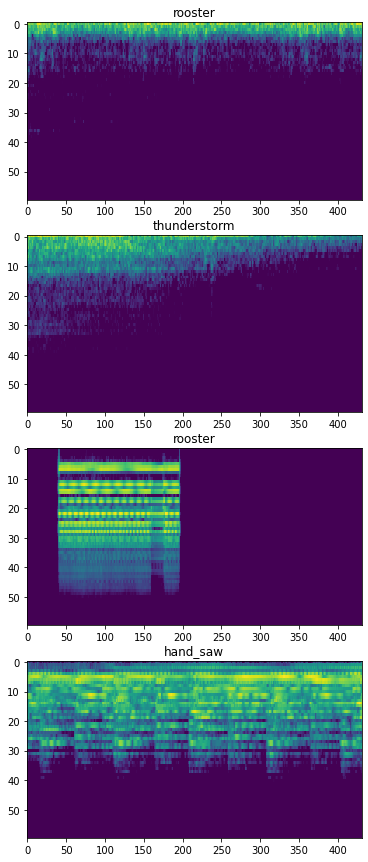

In [10]:
fig, ax = plt.subplots(4,1,figsize=(6,15))
for i in range(4):
    sample = int(np.random.uniform()*len(audio_list))
    ax[i].imshow(np.load(path+mel_names[sample]), interpolation='nearest', aspect='auto')
    ax[i].set_title(data_info['category'][sample])


my Dataset class, pytorch style

In [11]:
class Dataset:
    def __init__(self, x, y):
        self.x, self.y = x, y
        if len(x)!=len(y):
            print("ERROR first and second arguments must have the same length")

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [12]:
mel_names_dataset = Dataset(mel_names, list(data_info['target']))
print(mel_names_dataset[10][0])

10_door_wood_knock.npy


make Sequence class

In [47]:
class MelSequence(Sequence):
    # default batch size is the full dataset
    def __init__(self, dataset, batch_size):
        self.x, self.y = dataset[:][0], dataset[:][1]
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def debug(self, idx):
        print(type(self.batch_size))
        print(type(self.x[idx*self.batch_size:(idx + 1)*self.batch_size]))

    def __getitem__(self, idx):
        batch_x = self.x[idx*self.batch_size:(idx + 1)*self.batch_size]
        batch_y = self.y[idx*self.batch_size:(idx + 1)*self.batch_size]

        out_x = np.stack([np.load(path+mel_names) for mel_names in batch_x])
        return (out_x, batch_y)


In [48]:
batch_size = 4
mel_dataloader = MelSequence(mel_names_dataset, batch_size=batch_size)
mel_dataloader.debug(20)
print(np.shape(mel_dataloader[0][0]))
print(mel_dataloader[0][0])

<class 'int'>
<class 'list'>
(4, 60, 431)
[[[ 16.62052816  15.38532411  16.35902131 ... -28.450995   -28.450995
   -28.450995  ]
  [ 14.45847125  11.85157904  10.92093966 ... -28.450995   -28.450995
   -28.450995  ]
  [ 26.49297768  22.86678726  21.75886771 ... -28.450995   -28.450995
   -28.450995  ]
  ...
  [-28.450995   -28.450995   -28.450995   ... -28.450995   -28.450995
   -28.450995  ]
  [-28.450995   -28.450995   -28.450995   ... -28.450995   -28.450995
   -28.450995  ]
  [-28.450995   -28.450995   -28.450995   ... -28.450995   -28.450995
   -28.450995  ]]

 [[  5.53998297  -0.18799477   4.9802838  ...   2.18733095   1.41920933
    -4.26520433]
  [ 10.96097898  10.37482752   1.07912287 ...  -2.13484008  -6.08816261
   -11.74642807]
  [  8.41731231   4.33987034  -8.23908017 ...   4.45335142   0.10335436
    -6.41368677]
  ...
  [-39.90523607 -39.90523607 -39.90523607 ... -39.90523607 -39.90523607
   -39.90523607]
  [-39.90523607 -39.90523607 -39.90523607 ... -39.90523607 -39.905

test dataloader class

500
[0, 14, 36, 36]
(60, 431)


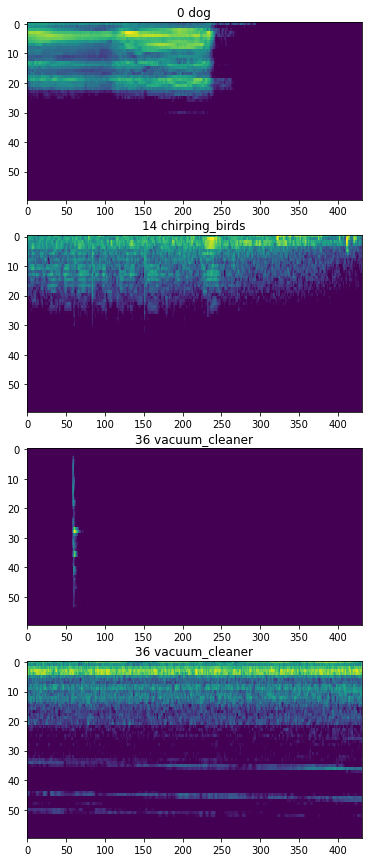

In [49]:
batch_size = 4
mel_dataloader = MelSequence(mel_names_dataset, batch_size=batch_size)
print(mel_dataloader.__len__())
batch_mel, batch_label = mel_dataloader[0]
print(batch_label)
print(np.shape(batch_mel[0]))

fig, ax = plt.subplots(4,1,figsize=(6,15))
for i in range(batch_size):
    ax[i].imshow(batch_mel[i], interpolation='nearest', aspect='auto')
    ax[i].set_title(str(batch_label[i])+' '+category_dict[batch_label[i]])


In [34]:
del audio_list

NameError: ignored

In [50]:
a = list(data_info['fold']!=5)
print(a)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

Use fold info for splitting train and validation

In [51]:
this_fold = 5
train_idx = list(data_info['fold']!=this_fold)
val_idx = [not a for a in train_idx]
train_dataset = Dataset(np.array(mel_names_dataset[:][0])[train_idx],
                        np.array(mel_names_dataset[:][1])[train_idx])
val_dataset = Dataset(np.array(mel_names_dataset[:][0])[val_idx],
                        np.array(mel_names_dataset[:][1])[val_idx])


print(len(train_dataset))
print(len(val_dataset))

1600
400


# Model classes

In [52]:
def basic_CNN():
    #consider 60x400x1 image
    #need to adapt from 60x431
    input = keras.Input(shape=(60,431,1))
    x = layers.Conv2D(32,   kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')(input)
    x = layers.Dropout(0.2)(x)
    # x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    # x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')(x) 
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')(x)  
    x = layers.Dropout(0.3)(x)
    # x = layers.BatchNormalization()(x)   
    x = layers.Flatten()(x)
    x = layers.Dense(50, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    # x = layers.BatchNormalization()(x)
    x = layers.Dense(50, activation='softmax')(x)
    mel_classifier = keras.Model(input, x, name='mel_classifier')
    return mel_classifier

# #test dimensions
mel_classifier = basic_CNN()
mel_classifier.summary()
# input = np.ones((1,60,400,1))
# out = net.predict(input)
# print(np.shape(out))

Model: "mel_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 60, 431, 1)]      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 30, 216, 32)       320       
_________________________________________________________________
dropout_24 (Dropout)         (None, 30, 216, 32)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 15, 108, 64)       18496     
_________________________________________________________________
dropout_25 (Dropout)         (None, 15, 108, 64)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 54, 64)         36928     
_________________________________________________________________
dropout_26 (Dropout)         (None, 8, 54, 64)      

# Training

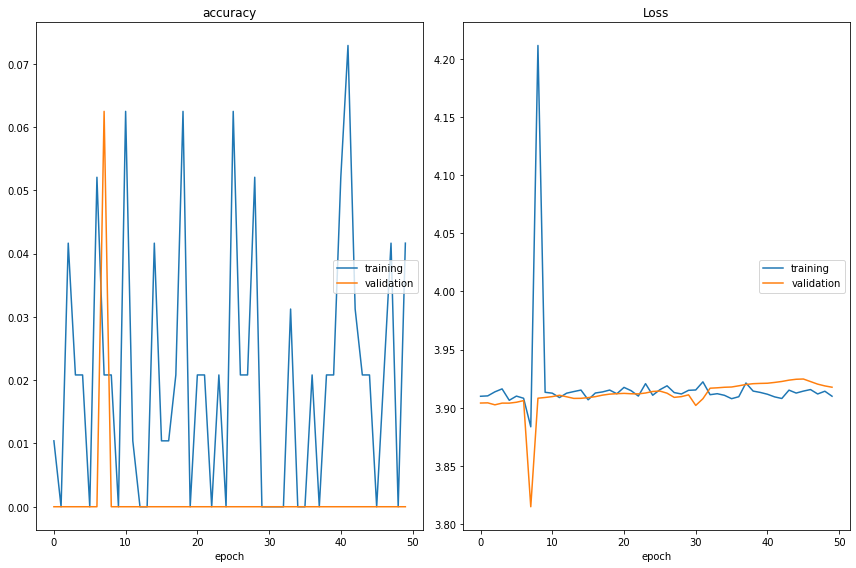

accuracy
	training         	 (min:    0.000, max:    0.073, cur:    0.042)
	validation       	 (min:    0.000, max:    0.062, cur:    0.000)
Loss
	training         	 (min:    3.884, max:    4.211, cur:    3.910)
	validation       	 (min:    3.815, max:    3.925, cur:    3.918)


In [55]:
batch_size = 16
epochs = 50

train_dataloader = MelSequence(train_dataset, batch_size)
val_dataloader =  MelSequence(val_dataset, batch_size)

mel_classifier.compile(optimizer=keras.optimizers.Adam(), loss = keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
mel_classifier.summary()


history = mel_classifier.fit(train_dataloader,
                            steps_per_epoch=int(len(train_dataloader)//batch_size),
                            epochs=epochs,
                            callbacks=[PlotLossesKeras()],
                            validation_data=val_dataloader,
                            validation_steps=int(len(val_dataloader)//batch_size),
                            verbose=0)


In [54]:
plt.plot(history.accuracy())

AttributeError: ignored